In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2, venn3

In [2]:
_path = '/home/lmh/work/repos/MINE/analyse/fig2/tss/temp'

all_enhanced_sig = np.load(os.path.join(_path, 'GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig.npy'), allow_pickle=True)
all_hr_sig = np.load(os.path.join(_path, 'GM12878_ATAC_H3K27ac_H3K4me3_2_100_all_hr_sig.npy'), allow_pickle=True)

enhanced_sigs = np.load(os.path.join(_path, 'GM12878_ATAC_H3K27ac_H3K4me3_2_100_enhanced_sigs.npy'), allow_pickle=True)
hr_sigs = np.load(os.path.join(_path, 'GM12878_ATAC_H3K27ac_H3K4me3_2_100_hr_sigs.npy'), allow_pickle=True)

_enhanced_sigs = np.load(os.path.join(_path, 'GM12878_ATAC_H3K27ac_H3K4me3_2_100__enhanced_sigs.npy'), allow_pickle=True)
_hr_sigs = np.load(os.path.join(_path, 'GM12878_ATAC_H3K27ac_H3K4me3_2_100__hr_sigs.npy'), allow_pickle=True)

CTCF_Path = '/data1/lmh_data/MINE/source/GM12878/CTCF_chiapet_peaks.bed'
POLR2A_path = '/data1/lmh_data/MINE/source/GM12878/POLR2A_chiapet_peaks.bed'


In [3]:
all_enhanced_sig = list(all_enhanced_sig.flatten())[0]
all_hr_sig = list(all_hr_sig.flatten())[0]
enhanced_sigs = list(enhanced_sigs.flatten())[0]
hr_sigs = list(hr_sigs.flatten())[0]
_enhanced_sigs = list(_enhanced_sigs.flatten())[0]
_hr_sigs = list(_hr_sigs.flatten())[0]

In [4]:
def show_venn(enhanced_sig_set, hr_sig_set):
    venn2(
        subsets=[hr_sig_set, enhanced_sig_set],
        set_labels=('Raw', 'MINE'),
        set_colors=((247/255, 129/255, 191/255), (51/255, 160/255, 44/255)))
    plt.show()

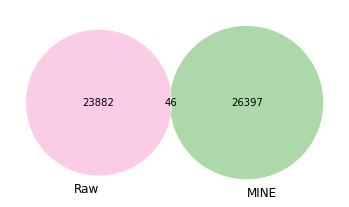

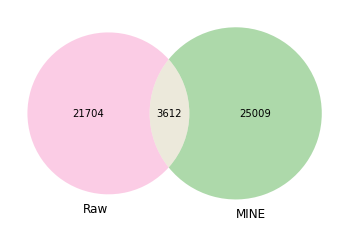

In [5]:
show_venn(enhanced_sigs, hr_sigs)
show_venn(_enhanced_sigs, _hr_sigs)

In [6]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_size = dict(
    ultra=45,
    large=35,
    middle=20,
    small=10,
    very_small=5
)

def set_plt(figsize=(10, 10)):
    params = {'axes.titlesize': figure_size['ultra'],
              'legend.fontsize': figure_size['middle'],
              'figure.figsize': figsize,
              'axes.labelsize': figure_size['ultra'],
              'xtick.labelsize': figure_size['ultra'],
              'ytick.labelsize': figure_size['ultra'],
              'figure.titlesize': figure_size['ultra'],
              'lines.linewidth': figure_size['very_small']}
    plt.rcParams.update(params)

    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

def set_Border(axes):
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(figure_size['very_small'])
    axes.spines['left'].set_linewidth(figure_size['very_small'])
    axes.tick_params(axis='both', width=figure_size['very_small'], length=figure_size['small'])

In [7]:
attentions = 50
center = attentions - 1

def read_chiqseq_file(path):
    _peaks = dict()
    with open(path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            peaks = list(range(left, right+1))
            if datas[0] not in _peaks.keys():
                _peaks[datas[0]] = set()
            for i in peaks:
                _peaks[datas[0]].add(i)
    return _peaks

def get_hit_indicators(significants, peaks):
    distance = np.zeros(attentions*2-1)
    
    for sig in significants:
        x, y = int(sig[0]), int(sig[1])
        for i in range(attentions):
            if (x+i) in peaks or (y+i) in peaks:
                distance[center-i] += 1
            if i != 0 and((x-i) in peaks or (y-i) in peaks):
                distance[center+i] += 1
            if (x+i) in peaks or (x-i) in peaks or (y+i) in peaks or (y-i) in peaks:
                break
    return distance

def show(x, mine_result, hr_result, title):
    set_plt()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True)
    axes.grid(False)
    axes.plot(x, mine_result, color=(0, 159/255, 232/255), label='MINE')
    axes.plot(x, hr_result, color=(255/255, 122/255, 23/255), label='Raw high resolution')
    
    set_Border(axes)
    axes.set_xticks([-40, 0, 40])
    axes.set_xticklabels(['-40K', 'Loop anchor', '40K'])

    plt.ylabel('Number of Peaks')
    plt.legend(
        facecolor='white', loc='upper right', framealpha=0, handletextpad=1, borderpad=0, borderaxespad=0
    ).get_frame().set_linewidth(0.0)

    plt.savefig('figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()


def figure(chip_seq_path):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        _peaks = read_chiqseq_file(chip_seq_path)
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], _peaks['chr{}'.format(chr)])
        hr_result = get_hit_indicators(all_hr_sig[chr], _peaks['chr{}'.format(chr)])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result)

In [8]:
mine_sig = pd.DataFrame(list(_enhanced_sigs))
raw_sig = pd.DataFrame(list(_hr_sigs))

def get_chiqseq_loop(_path, name):
    _chiqseq = read_chiqseq_file(_path)
    chiqseq = set()
    for chrom in _chiqseq.keys():
        for peak in _chiqseq[chrom]:
            _raw_sig = raw_sig[(raw_sig[2]==chrom)&((raw_sig[0]==peak)|(raw_sig[1]==peak))]
            _raw_sig = set(_raw_sig.apply(lambda x: tuple(x), axis=1).values.tolist())

            _mine_sig = mine_sig[(mine_sig[2]==chrom)&((mine_sig[0]==peak)|(mine_sig[1]==peak))]
            _mine_sig = set(_mine_sig.apply(lambda x: tuple(x), axis=1).values.tolist())

            _sigs = set.union(_raw_sig, _mine_sig)
            if _sigs:
                chiqseq = set.union(_sigs, chiqseq)
            else:
                chiqseq.add((peak, peak, chrom))

    venn3(subsets=[_hr_sigs, _enhanced_sigs, chiqseq], set_labels=('Raw', 'MINE', name))
    plt.savefig('figure_file/venn_{}.pdf'.format(name), format='pdf', bbox_inches='tight')
    plt.show()

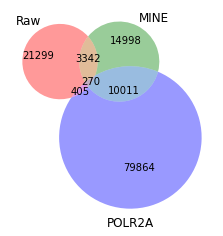

In [9]:
POLR2A = get_chiqseq_loop(POLR2A_path, 'POLR2A')

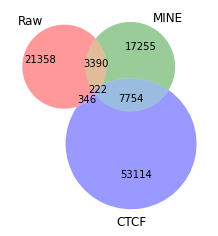

In [10]:
CTCF = get_chiqseq_loop(CTCF_Path, 'CTCF')

In [11]:
tss_file_path = '/data1/lmh_data/MINE/source/GM12878/Homo_sapiens.GRCh38.104.chr.gff3'

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_location = dict()
    gene_info = dict()
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if data[6] == '+':
                _location = data[3]
            elif data[6] == '-':
                _location = data[4]
            else:
                print('error')
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            if chromosome not in gene_location:
                gene_location[chromosome] = set()
            gene_location[chromosome].add(int(int(_location)/1000))
            
            _tmp = data[-1].split('Name=')
            if len(_tmp) < 2:
                continue
            gene_names = _tmp[1].split(';')[0]
            gene_ids = data[-1].split('ID=')[1].split(',')[0].split(';')[0]
            
            if chromosome not in gene_info:
                gene_info[chromosome] = set()
            gene_info[chromosome].add((int(int(_location)/1000), gene_names, gene_ids, data[-1].replace('\n', '')))
    return gene_location, gene_info

def figure_tss(locations):
    all_enhanced_result = np.zeros(attentions*2-1)
    all_hr_result = np.zeros(attentions*2-1)

    for chr in range(1, 23):
        if chr not in locations:
            continue
        enhanced_result = get_hit_indicators(all_enhanced_sig[chr], locations[chr])
        hr_result = get_hit_indicators(all_hr_sig[chr], locations[chr])

        all_enhanced_result += enhanced_result
        all_hr_result += hr_result

    show(list(range(-attentions+1, attentions)), all_enhanced_result, all_hr_result, 'TSS overlap in GM12878')

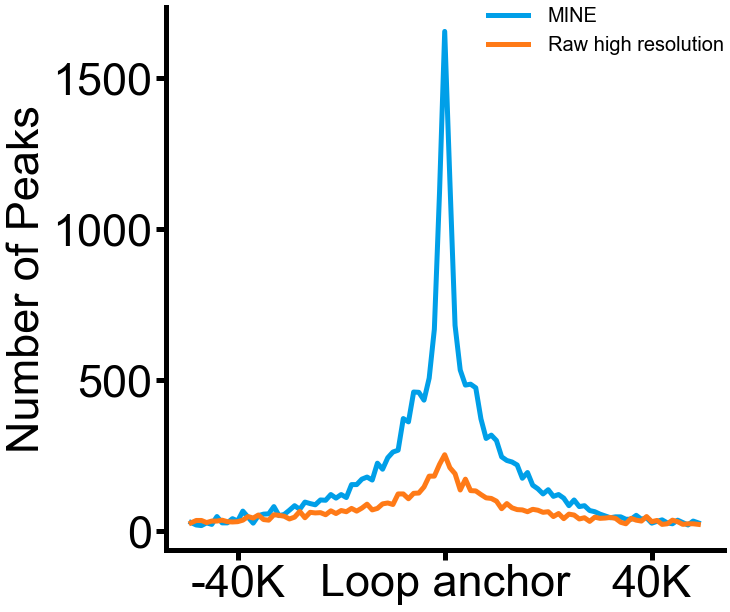

In [12]:
figure_tss(get_tss_gene_info('protein_coding')[0])